# Metin's Ultimate Guide to get rich by forecasting stock returns using a Crystal Ball ...uhm...I mean ARIMA model

In [18]:
# Import libraries and dependencies
import numpy as np
from numpy import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
%matplotlib inline

In [19]:
# Load .env enviroment variables
from dotenv import load_dotenv
abs_path = Path(r'C:/Users/metin/Documents/nufintech/.env')
load_dotenv(abs_path) 


# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [20]:
# Set the ticker
ticker = "SPY"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2015-05-04", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-06-24", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
    ).df



In [21]:
df.head()

SPY                                   
                             open    high     low   close     volume
time                                                                
2015-05-04 00:00:00-04:00  211.23  212.02  211.10  211.34   56064438
2015-05-05 00:00:00-04:00  211.03  211.46  208.73  208.90   91499087
2015-05-06 00:00:00-04:00  209.56  209.93  206.76  208.03  101710540
2015-05-07 00:00:00-04:00  207.92  209.38  207.52  208.87   70211277
2015-05-08 00:00:00-04:00  210.87  211.86  210.78  211.62   93316229

In [22]:
df.tail()

SPY                                     
                              open    high       low   close     volume
time                                                                   
2020-06-18 00:00:00-04:00  310.005  312.30  309.5100  311.74  128833528
2020-06-19 00:00:00-04:00  314.170  314.38  306.5300  308.56  223746346
2020-06-22 00:00:00-04:00  307.990  311.05  306.7500  310.68   61401568
2020-06-23 00:00:00-04:00  313.490  314.49  311.6101  312.03   56029323
2020-06-24 00:00:00-04:00  309.840  310.51  302.1000  304.12  109892325

In [23]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.tail()

,close
2020-06-18,311.74
2020-06-19,308.56
2020-06-22,310.68
2020-06-23,312.03
2020-06-24,304.12


In [24]:
# Use the `pct_change` function to calculate daily returns of AAPL
daily_returns = df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns.head()

,close
2015-05-05,-0.011545
2015-05-06,-0.004165
2015-05-07,0.004038
2015-05-08,0.013166
2015-05-11,-0.004773


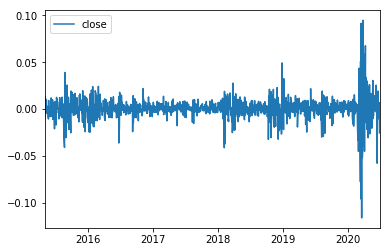

In [25]:
daily_returns.plot()

### Up until now, we coppped out and pulled of some "bush league forecasting" by using the average daily return to forecast

In [8]:
# Use the `mean` function to calculate the mean of daily returns for AAPL
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.000353930204059928

# Now we are ready to forecast Major League Style with ARIMAs

In [26]:
def metin_s_dickey_fuller(series):
    from statsmodels.tsa.stattools import adfuller
    series.dropna(inplace=True)
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value:        %f ' % result[1])
    print('Lags used:      %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))
    if result[1]<0.05:
        print(f'\nWohoo! The p-value is below the significance level of 0.05. \n\nWe can reject the hypothesis that the time series is non-stationary. GO PACK GO!!!')
    else: 
        print('\nwah waaah..p-value is above the significance level of 0.05. \n\nWe cannot reject the hypothesis that the time series is non-stationary. Better luck next time buddy!!')
    
#http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

In [27]:
metin_s_dickey_fuller(daily_returns['close'])

ADF Statistic: -10.961881
p-value:        0.000000 
Lags used:      8
Critical Values:
1%: -3.435
5%: -2.864
10%: -2.568

Wohoo! The p-value is below the significance level of 0.05. 

We can reject the hypothesis that the time series is non-stationary. GO PACK GO!!!


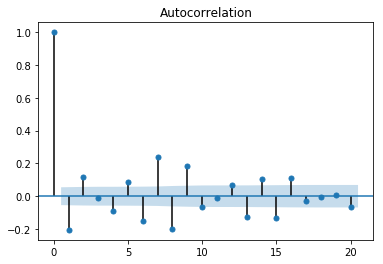

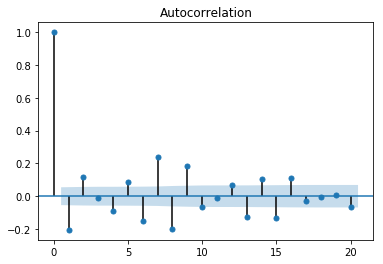

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(daily_returns['close'], lags=20)

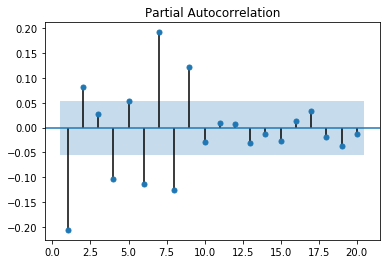

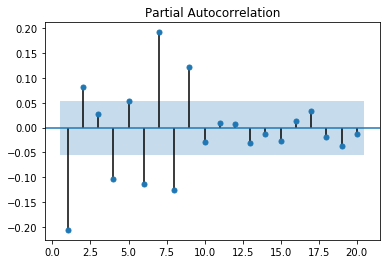

In [29]:
plot_pacf(daily_returns['close'], zero=False, lags=20)

In [30]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(daily_returns['close'], order=(1, 0, 1))

C:\Users\metin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [31]:
results = model.fit()

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 1295
Model:                     ARMA(1, 1)   Log Likelihood                3917.510
Method:                       css-mle   S.D. of innovations              0.012
Date:                Thu, 25 Jun 2020   AIC                          -7827.020
Time:                        19:01:24   BIC                          -7806.355
Sample:                             0   HQIC                         -7819.265
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0004      0.000      1.277      0.202      -0.000       0.001
ar.L1.close    -0.4182      0.080     -5.222      0.000      -0.575      -0.261
ma.L1.close     0.2176      0.084      2.599      0.009       0.053       0.382
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.3911           +0.0000j            2.3911            0.5000
MA.1           -4.5960           +0.0000j            4.5960            0.5000
-----------------------------------------------------------------------------
"""

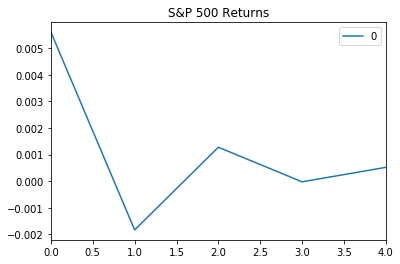

In [33]:
# Visualize the forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="S&P 500 Returns")

In [34]:
results.forecast(steps=1)[0]

array([0.00560534])

If you are up for the challenge, submit your forecast for the S&P 500 return (close to close) as a simple binary variable to our forecasting competition(1=positive return, 0=negative return), starting Mon Jul 29th 2020 until Friday Jul 3rd 2020. Forecasts have to be submitted for the next day by midnight the day before.